# 8.5. Single-Objective Optimisation (SODO): Bridge Design Problem

```{note}
Press the rocket symbol on the top right of the page to make the page interactive and play with the code! 
```

In some cases, engineering design problems are simplified to a single-objective optimisation (SODO). This means that all weights are set to zero except for one objective, effectively focusing the analysis on just one stakeholder’s interest. While such simplifications can be useful as a first step, they should be understood as special cases of multi-objective optimisation (MODO).

## Problem statement 

To illustrate, consider a bridge design where we limit the design problem to the determination of
the optimal span and the clearance height of the bridge. Assume that there are two
decision makers (stakeholders) that have conflicting interests: 
1) **The municipality**, interested in the costs of the bridge. 
2) **The waterway users**, interested in the
waiting time when the bridge is closed for waterway users. 


**Step 1: Specify the design variables**

For this problem we have two controllable design variables:
1) $x_1$: the bridge span, and
2) $x_2$: the clearance height of the bridge. 

**Step 2: Retrieve decision maker's objectives**

The municipality wants the cost to be minimised which becomes the first objective function $O_1$, whereas the waterway users want the waiting time to be minimised which becomes the second objective function $O_2$.

**Step 3: Determine the preference functions for each objective**

The costs are a function of the material use which in turn is a function of both the span and clearance height. We assume a linear relationship between costs $O_1$ and material use $F_1$ defined by coefficient $c_1 = 3$.

$$O_1 = c_1 F_1$$

We also assume a linear relationship between material use and both span and clearance height defined by coefficients $c_2 = 4$ and $c_3 = 7$ respectively.

$$F_1 = c_2 x_1 + c_3 x_2$$

The first objective to be minimised then becomes:

$$O_1 = c_1 F_1 = c_1 c_2 x_1 + c_1 c_3 x_2$$

The waiting time is a function of the traffic flow which in turn is a function of both the span and clearance height. We again assume a linear relationship between waiting time $O_2$ and traffic flow $F_2$, and reads as:

$$O_2 = −c_4 F_2 + w_0; F_2 = c_5 x_1 + c_6 x_2$$

where $w_0 > 0$. 

We also assume: 
(a) the coefficient $c_4 = 1.2$;
(b) a maximal waiting time of $w_0 = 100$ (for a traffic flow that is ’nearly’ zero); 
(c) a linear relationship between traffic flow and both span and clearance height defined by coefficients $c_5 = 1.7$ and $c_6 = 1.9$ respectively. 

The second objective to be minimised then becomes:

$$O_2 = −c_4 F_2 + w_0 = −c_4 c_5 x_1 − c_4 c_6 x_2 + w_0$$

**Step 4: To each objective assign decision maker's weights**

For this problem the weights are assumed to be equal, i.e. $w_1 = w_2 = 0.5$.


**Step 5: Determine the design constraints**

The constraints relate to the minimum and maximum span and the minimum and
and maximum clearance height:

$$1 ≤ x_1 ≤ 5; 3 ≤ x_2 ≤ 8$$


**Step 6: Find the optimal design having the highest preference score**

The graphical representation of this problem and both optimal solutions are shown in the figure below. Optimisation is carried out using MILP and Scipy Minimize. 
The design points are $(x1, x2) = (1, 3)$ and $(5, 8)$ for costs and waiting time respectively. 

Therefor the
- costs are minimised at $(x1, x2) = (1, 3)$, and
- waiting time is minimised at $(x1, x2) = (5, 8)$.

<div style="text-align: center;">
  <img src="./images/bridge_results.png" alt="Chapter 11" width="70%">
  <p>Graphical representation of the bridge design problem.</p>
</div>

The graphical results show that SODO produces different optima depending on the selected objective.

## Python code for bridge design problem

Type of algorithm used for single objective optimisation: Scipy minimize and MILP \
Type of algorithm used for multi objective optimisation: Genetic Algorithm (tetra) \
Number of design variables: 2 \
Number of objective functions: 2 \
Bounds: yes \
Constraints: no \
Type of problem: linear 

In [46]:
import micropip
await micropip.install("urllib3 ")
await micropip.install("requests")

import numpy as np
import pandas as pd
from scipy.optimize import minimize, LinearConstraint, milp
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

from genetic_algorithm_pfm.a_fine_aggregator_main import a_fine_aggregator

%matplotlib inline
plt.rcParams['figure.dpi'] = 400
plt.rcParams.update({'font.size': 14})

### MILP and Minimise

Scipy has two algorithms that can easily be used for optimisation: MILP and Minimize. The former is especially useful for mixed-integer problems: problems where one or more of the variables is an integer variable. The latter is, however, more straightforward in its use.

To show their applicability, the same problem is worked out with both methods in this notebook.

In [47]:
# define constants
c1 = 3   # costs per material
c2 = 4   # material used per metre bridge span
c3 = 7   # material used per metre air draft
c4 = 1.2   # relation between waiting time and traffic flow
c5 = 1.7   # traffic flow per metre bridge span
c6 = 1.9   # traffic flow per metre air draft

WT0 = 100   # minimal waiting time

#### MILP

In [48]:
# first, define the objective function. Since it is linear, we can just provide the coefficients with which x1 and x2
# are multiplied. Note the -1: we need to maximize, however, milp is a minimization algorithm!
c_costs = 1 * np.array([c1 * c2, c1 * c3])
c_wait_time = -1 * np.array([c4 * c5, c4 * c6])

# next, define the constraints. For this we first provide a matrix A with all the coefficients x1 and x2 are multiplied.
A = np.array([[1, 0], [0, 1]])

# next we determine the upper bounds as vectors
b_u = np.array([5, 8])

# finally, we need to define the lower bound. In our case, these are taken as 0
b_l = np.array([1, 3])

# we can now define the LinearConstraint
constraints = LinearConstraint(A, b_l, b_u)

# the integrality array will tell the algorithm what type of variables (0 = continuous; 1 = integer) there are
integrality = np.zeros_like(c_costs)

# Run the optimization
result1 = milp(c=c_costs, constraints=constraints, integrality=integrality)
result2 = milp(c=c_wait_time, constraints=constraints, integrality=integrality)

print('Results MILP')
print(f'Objective 1 is minimal for x1 = {result1.x[0]} and x2 = {result1.x[1]}. The costs are then {result1.fun}.')
print(f'Objective 2 is minimal for x1 = {result2.x[0]} and x2 = {result2.x[1]}. '
      f'The wait time is then {result2.fun + WT0}.')

Results MILP
Objective 1 is minimal for x1 = 1.0 and x2 = 3.0. The costs are then 75.0.
Objective 2 is minimal for x1 = 5.0 and x2 = 8.0. The wait time is then 71.56.


#### Minimize

In [49]:
# define objectives
def objective_costs(x):
    x1, x2 = x

    F1 = c2 * x1 + c3 * x2

    return c1 * F1


def objective_wait_time(x):
    x1, x2 = x

    F2 = c5 * x1 + c6 * x2

    return -1 * c4 * F2 + WT0


# define bounds for two variables
bounds = ((1, 5), (3, 8))

# initiate optimization
result1 = minimize(objective_costs, x0=np.array([1, 1]), bounds=bounds)
result2 = minimize(objective_wait_time, x0=np.array([1, 1]), bounds=bounds)

optimal_result_O1 = result1.fun
optimal_result_O2 = result2.fun

# print results
print('Results Minimize')
print(f'Objective 1 is minimal for x1 = {result1.x[0]} and x2 = {result1.x[1]}. The costs are then {result1.fun}.')
print(f'Objective 2 is minimal for x1 = {result2.x[0]} and x2 = {result2.x[1]}. The wait time is then {result2.fun}.')
print()

Results Minimize
Objective 1 is minimal for x1 = 1.0 and x2 = 3.0. The costs are then 75.0.
Objective 2 is minimal for x1 = 5.0 and x2 = 8.0. The wait time is then 71.56.



#### Plot the results

After optimising using the minimise algorithm the solution space and the objective function are plotted.

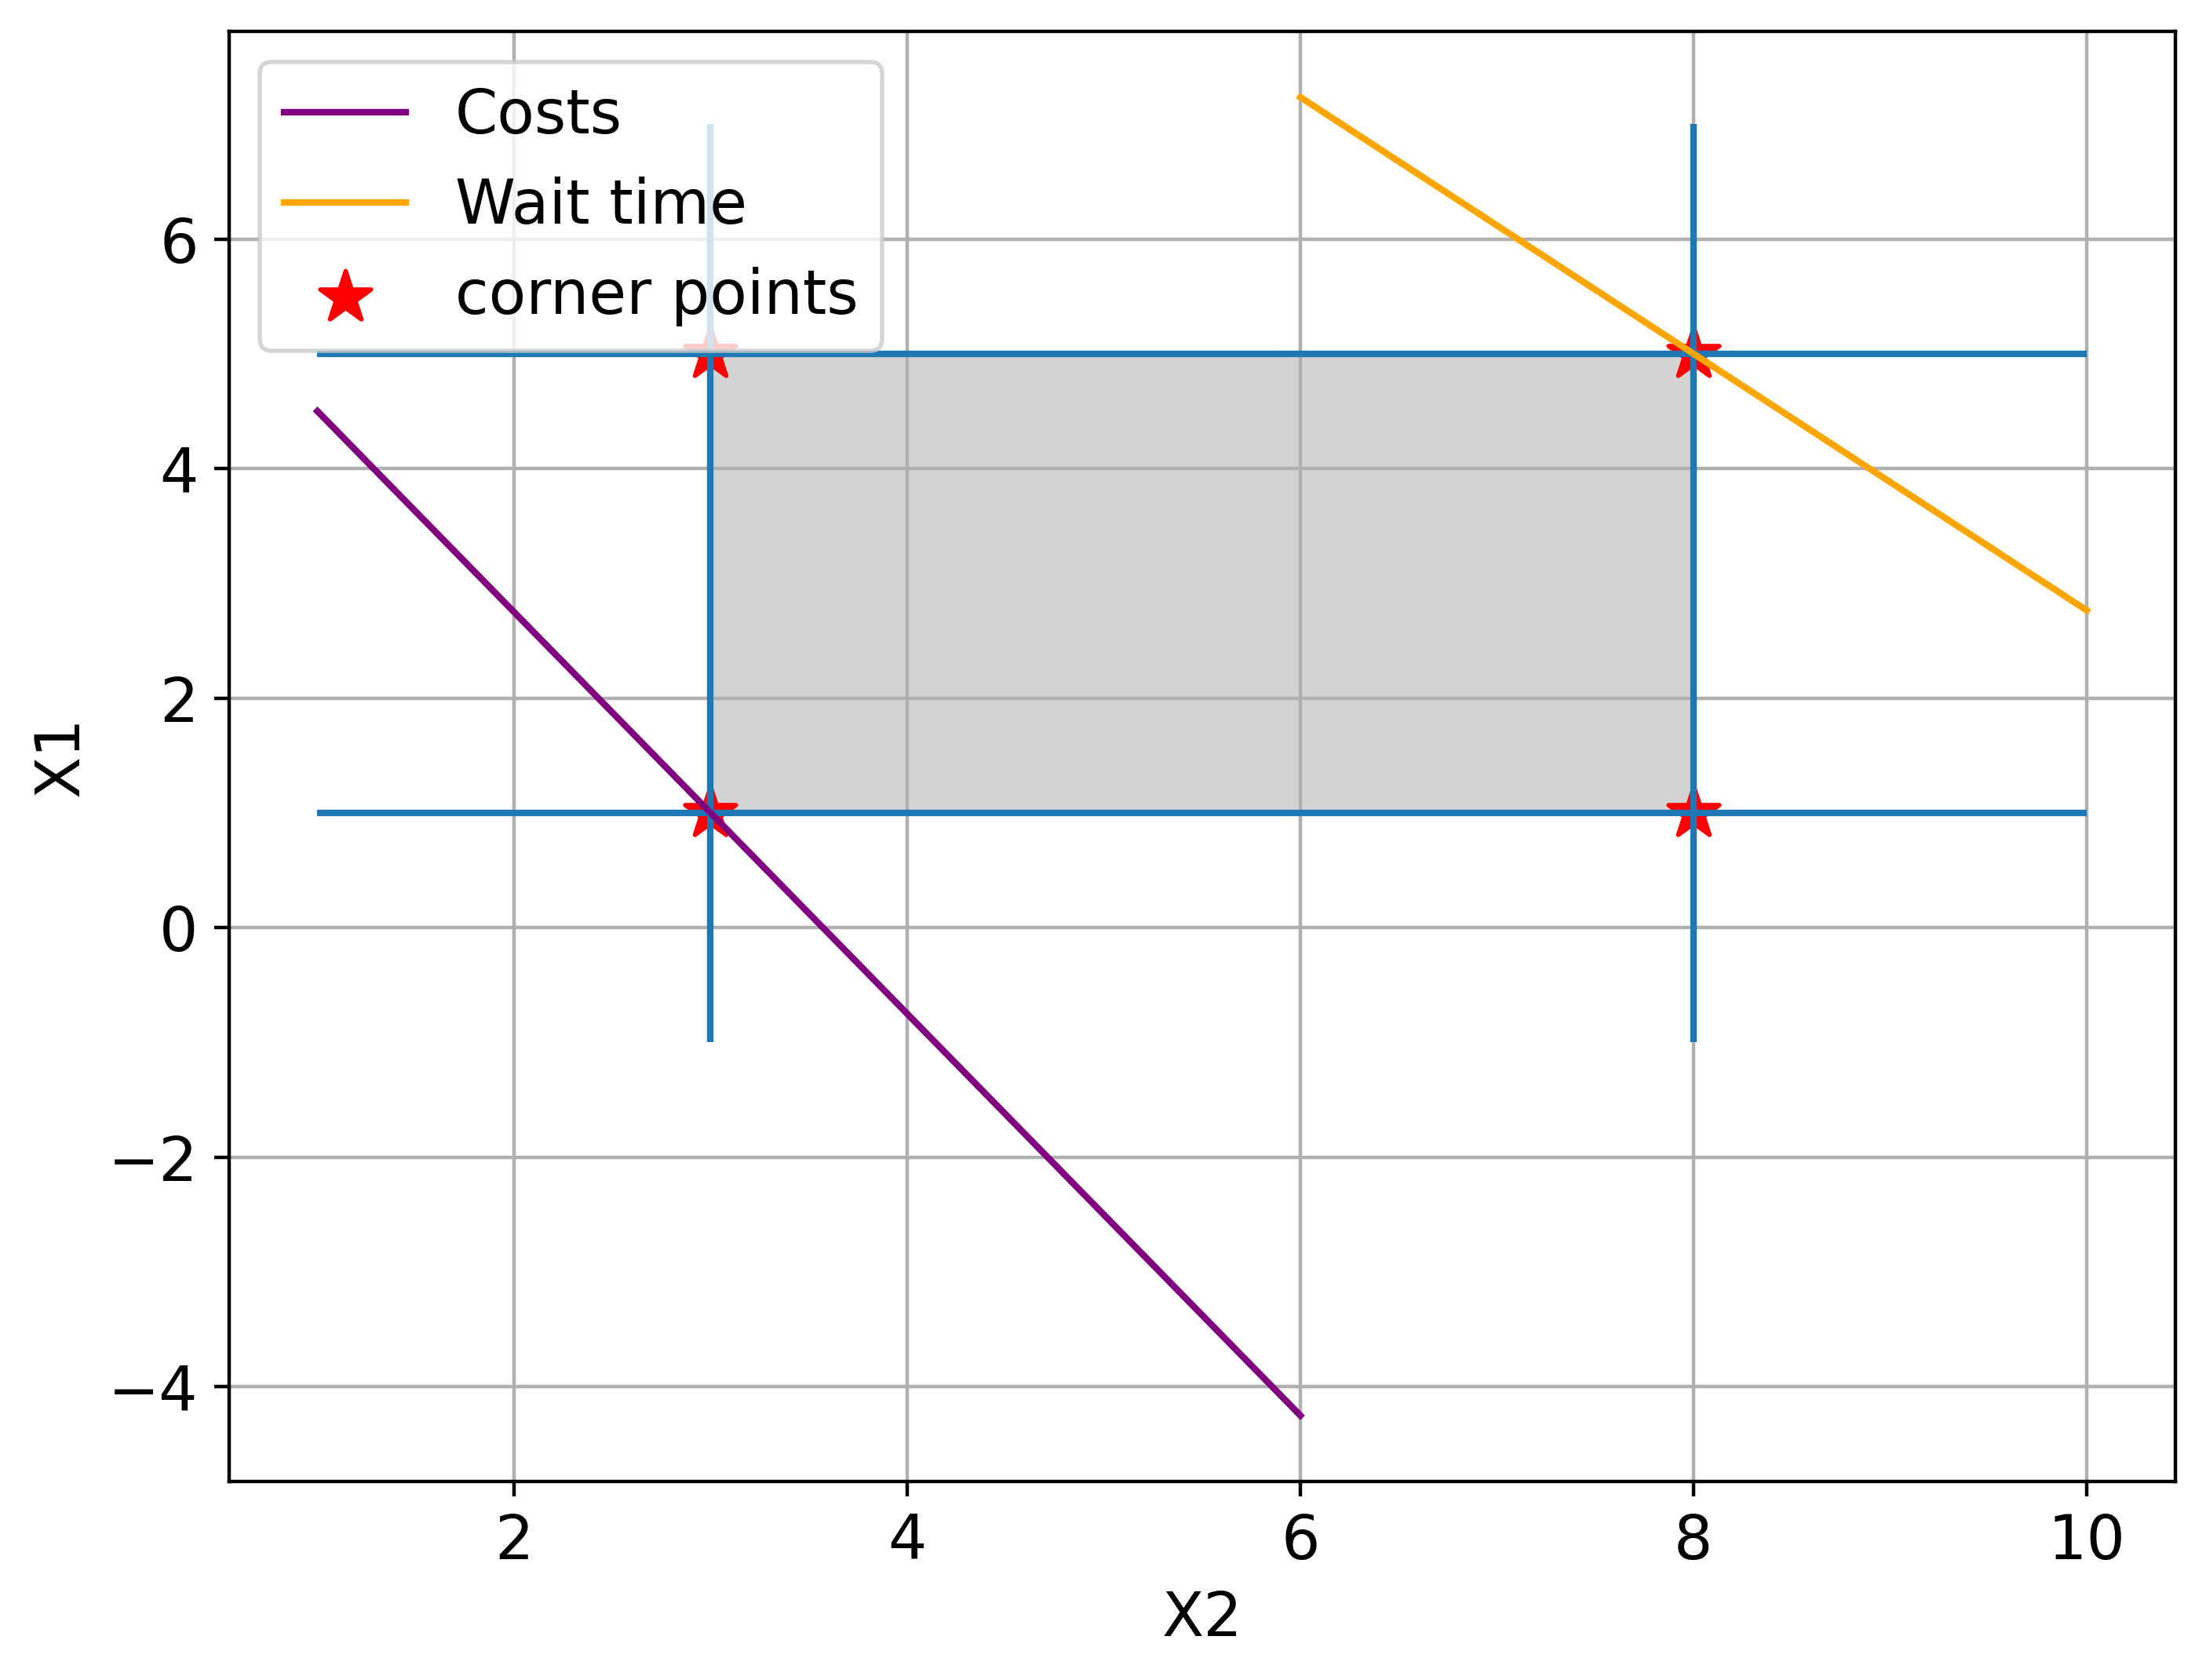

In [50]:
# plot graphical solution
fig, ax = plt.subplots(figsize=(8, 6))

# Draw constraint lines
ax.vlines(3, -1, 7)
ax.vlines(8, -1, 7)
ax.hlines(1, 1, 10)
ax.hlines(5, 1, 10)

# Draw the feasible region
feasible_set = Polygon(np.array([[3, 1],
                                 [8, 1],
                                 [8, 5],
                                 [3, 5]]),
                       color="lightgrey")
ax.add_patch(feasible_set)

ax.set_xlabel('X2')
ax.set_ylabel('X1')

# Draw the objective function
x2 = np.linspace(1, 6)
ax.plot(x2, (optimal_result_O1 - c1 * c3 * x2) / (c1 * c2), color="purple", label='Costs')
x2 = np.linspace(6, 10)
ax.plot(x2, (WT0 - c4 * c6 * x2 - optimal_result_O2) / (c4 * c5), color="orange", label='Wait time')

ax.scatter([3,3,8,8], [1,5,1,5], marker='*', color='red', label='corner points', s=150)

ax.legend()
ax.grid();
